# Introduction

The internet is a rich source of information. There are oppotunities to collect this information in a variety of ways. Services like Twitter etc often provide application programming interfaces (APIs) that allow programmers to hook into the data collected and then analyse or display that data. Alternatively there are also large and complex datasets deposited onto the web for anyone with the relevant skills and time to analyse. In this unit we will use python to access data available as an Excel file on the internet and build on the analysis skills from the previous unit.

## The data

The UK government collects data on many and varied social and economic indicators. These data are hosted on the [data.gov.uk](http://data.gov.uk/) website. There is a useful [faq](http://data.gov.uk/faq) which explains the purpose of the data portal and the types of data available. In this tutorial we'll examine the rates of childhood obesity in England. In January 2015 the BBC reported that rates of childhood obesity in England were [levelling off](http://www.bbc.co.uk/news/health-31041864). We will use the public data to examine that claim.

The first step is to identify the data we want to use. The [data.gov.uk](http://data.gov.uk/) website has a search tool on the front page and if we type 'obesity' into the search box we get back a list of results. On the left hand side of the page under the section 'Resource format' we can see that 12 of these resources are in Excel format. If we click on the xls link here we are taken to a list of these 12 resources. In this list we see that there is an Excel resource for 'Statistics on Obesity, Physical Activity and Diet, England'. This Excel spreadsheet is the data we want.

Once we have found this on the data portal we have to capture it for analysis. We could simply download the [csv](http://www.hscic.gov.uk/catalogue/PUB16988/Obes-phys-acti-diet-eng-2015-tab.csv) file (on the same page) and use this locally but since the point of this exercise is to examine how we can use python for the whole process we'll instead use python to download the [Excel](http://www.hscic.gov.uk/catalogue/PUB16988/Obes-phys-acti-diet-eng-2015-tab.xlsx) file. Once we have that we'll use ```pandas``` to examine the data.

The first step on our way is to load the libraries we will require. We'll use the ```urllib2``` library to capture the Excel spreadsheet. From the [documentation](https://docs.python.org/2/library/urllib2.html):
>The urllib2 module defines functions and classes which help in opening URLs (mostly HTTP) in a complex world — basic and digest authentication, redirections, cookies and more.

Basically what we need to know is that the ```urllib2``` library will allow us to download content from webpages. Indeed one common use of this library is to download whole webpages and then use further processing to extract useful information. Uniform resource locators (URLs) identify resources (e.g. webpages or in this case an Excel file) on the internet. Given a URL the ```urllib2``` library can fetch the resource at that URL and make it available to python. 

The first thing we have to do is 'request' the object at the URL. Once the 'request' is in place we can then open the object. The ```urllib2``` library provides two functions ```Request``` and ```urlopen``` for each of these stages. We have to provide the ```Request``` function with a URL. The easiest way to get the URL for the resource we want is to right click (or ctrl-click if on a mac) the 'Download' link for the [Excel](http://www.hscic.gov.uk/catalogue/PUB16988/Obes-phys-acti-diet-eng-2015-tab.xlsx) file on the [data.gov.uk](http://data.gov.uk/dataset/statistics_on_obesity_physical_activity_and_diet_england) site and then click on 'Copy Link Location' on the pop up dialogue. This should copy the download URL to the clipboard. Then we can just copy it into a variable in our script.

In [3]:
# Based on https://realpython.com/blog/python/analyzing-obesity-in-england-with-python/
# first import the libs we need
from urllib2 import Request, urlopen
import pandas as pd
import matplotlib.pyplot as plt
# so the notebook will show our plots
%matplotlib inline 
import seaborn as sns
sns.set_style("white")

# Set up URL and get file
# URL pasted in
request_object = Request("http://www.hscic.gov.uk/catalogue/PUB16988/Obes-phys-acti-diet-eng-2015-tab.xlsx")
# Open the file
file_object = urlopen(request_object)

Now we are pointing to the file we want online and we want to open it in ```pandas```. We use the ```ExcelFile``` function of ```pandas``` to read the file from the open URL directly. 

In [4]:
data = pd.ExcelFile(file_object) # read with pandas
print data

Printing the data object shows its location in memory. Not very useful to us but at least we know the process worked.

If you download the file directly and look at it in Excel you'll see that it contains several tabs with different information in each tab. The data we're interested in is in tab 2. 

We can use the ```sheet_names``` method to find out the names of the individual tabs (recall that the ```u``` means [unicode](https://en.wikipedia.org/wiki/Unicode)). We want the data in tab 2 (i.e. 7.2) so we'll have to refer to this by name. We'll also skip the first 3 and last 14 rows since they don't contain data we're interested in.

In [5]:
print data.sheet_names # get tab names

[u'Chapter 7', u'7.1', u'7.2', u'7.3', u'7.4', u'7.5', u'7.6', u'7.7', u'7.8', u'7.9', u'7.10', u'7.11', u'7.12', u'7.13', u'7.14']


In [6]:
# Read 2nd section, the obesity figures by age data
data_age = data.parse(u'7.2', skiprows=3, skipfooter=14)
data_age.head() # first few entries

,Year,Unnamed: 1,Total,Under 16,16 to 24,25 to 34,35 to 44,45 to 54,55 to 64,65 to 74,75 and over,Unknown
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013/146,NaN,9325,548,352,1209,2133,2839,1663,458,123,0
2,2012/136,NaN,10957,556,356,1437,2744,3305,1965,495,99,0
3,2011/12,NaN,11736,495,391,1484,3104,3581,2119,468,94,0
4,2010/11,NaN,11574,525,375,1425,3277,3573,1820,456,115,8


We can see that ```pandas``` has recognised the column names but that there is a row and a column with ```NaN``` values. These need to be removed. 

There is a [```dropna```](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html) function in ```pandas``` and we can apply this to the rows and columns. In ```pandas``` the rows and columns are referred to as *axes*; axis 0 is the rows and axis 1 is the columns. In the call to the ```dropna``` function we pass in a tuple indicating that we want to drop ```NaN``` values from both rows and columns but only where **every** value in the row or column is ```NaN``` (```how='all'```). The ```inplace = True``` argument acts on the dataframe we have rather than making a copy in memory. Note that this means the original data is changed. This might not be what you always want.

In [7]:
data_age.dropna(axis = (0,1), how='all', inplace=True) # drop NaN
data_age.head(n=8)

,Year,Total,Under 16,16 to 24,25 to 34,35 to 44,45 to 54,55 to 64,65 to 74,75 and over,Unknown
1,2013/146,9325,548,352,1209,2133,2839,1663,458,123,0
2,2012/136,10957,556,356,1437,2744,3305,1965,495,99,0
3,2011/12,11736,495,391,1484,3104,3581,2119,468,94,0
4,2010/11,11574,525,375,1425,3277,3573,1820,456,115,8
5,2009/10,10571,632,361,1348,3132,3076,1555,378,87,2
6,2008/09,7988,775,322,1013,2359,2133,1099,221,63,3
7,2007/08,5018,747,228,564,1469,1198,598,157,53,4
8,2006/075,3862,656,184,461,1069,872,459,118,43,0


## Lambda functions

Inspecting the Year column shows that there is a problem with the first, second and  eighth entries. These have an extra number added to the end due to a superscript in the original data file. This is annoying but we can drop the extra number fairly easily. We could just substitute in the correct label since we only have 3 corrections to make.

```python
# simple clean up
data_age.Year[1] = '2013/14'
data_age.Year[2] = '2012/13'
data_age.Year[8] = '2006/07'
```

However this isn't very general and if we had 10 or more corrections to make it would become really tedious. Instead we'll take this opportunity to demonstrate two python functions, ```map``` and ```lambda```. The [```map```](https://docs.python.org/2/library/functions.html#map) function applies (or maps) a function to every value in some iterable. In our case the iterable is the value in the Year column of our data. In python ```lambda``` functions are small one off functions you can apply on the fly. They're also called anonymous functions (since they aren't named like full functions). Our strategy here is to apply a lambda function to every value of the Year column in the data that will return only the first 7 characters of the Year.

In [8]:
data_age['Year'] = data_age['Year'].map(lambda x: str(x)[0:7])
print data_age['Year']

1     2013/14
2     2012/13
3     2011/12
4     2010/11
5     2009/10
6     2008/09
7     2007/08
8     2006/07
9     2005/06
10    2004/05
11    2003/04
Name: Year, dtype: object


Let's break down that last command. With structures like this it's often easier to work from the inside out.

* ```(lambda x: str(x)[0:7])``` : ```lambda x:``` tells python that we want to do something to a variable (called x). Specifically we want to take x and convert it to a ```str``` type and then return only the first 7 characters of that string ```[0:7]```. Note that colon - we indicate our ```lambda``` function the same way we indicate a full function.
* ```map``` : applies the anonymous function to each element in our selected data
* ```data_age['Year']``` : selects the data we want to act on

So altogether from left to right this says take the Year data and for every year convert it to a string and give me back just the first 7 characters.

We could also have done this with a list comprehension (shown below) but it was a good opportunity to introduce ```map``` and ```lambda``` which are both handy!

```python
# List comprehension version
data_age['Year'] = [str(yr)[0:7] for yr in data_age['Year']]
```

At the moment the index for this data is an arbitrary integer. Since we're going to be plotting this data by Year it's sensible to re-index the data by Year.

In [9]:
# change the index to year to make plotting easier
data_age.set_index('Year', inplace=True)
data_age.head()

,Total,Under 16,16 to 24,25 to 34,35 to 44,45 to 54,55 to 64,65 to 74,75 and over,Unknown
Year,,,,,,,,,,
2013/14,9325,548,352,1209,2133,2839,1663,458,123,0
2012/13,10957,556,356,1437,2744,3305,1965,495,99,0
2011/12,11736,495,391,1484,3104,3581,2119,468,94,0
2010/11,11574,525,375,1425,3277,3573,1820,456,115,8
2009/10,10571,632,361,1348,3132,3076,1555,378,87,2


Now we've got to the stage where we have cleaned up data we can use for plotting and examining the trends in obesity for different age groups over time. If you try this with the data as it is you'll find that the most recent years are plotted first - which is silly! So we'll reverse the index (Year) so we start with 2003.

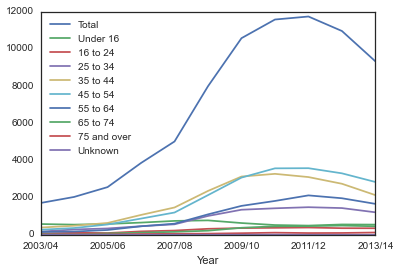

In [10]:
data_age.sort_index(ascending=True, inplace=True)
data_age.plot()
plt.show()

Generally it looks as though obesity has been increasing over the years but the Total variable dominates this plot and makes it hard to see what's going on in the individual age groups. We should drop Total from the plot and re-examine the data. We use the ```.drop``` function and pass an axis (here the column) to drop.

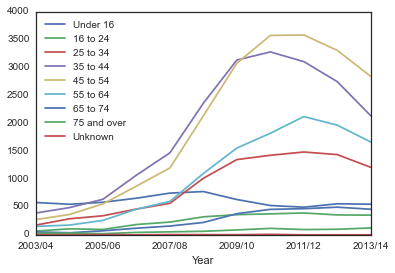

In [11]:
# Drop the total column and re-plot
data_age_minus_total = data_age.drop('Total', axis=1) # drop the Total column
data_age_minus_total.plot()
plt.show()

It's clearer now that for certain age groups there has been a steep increase in obesity. We started with a questions about obesity in children so let's do a final plot to examine our original question and see if childhood and adult obesity display the same trend.

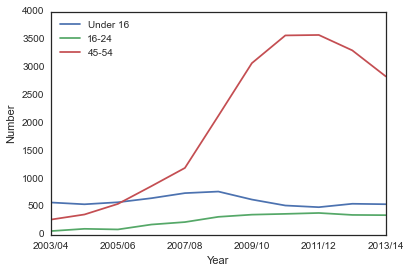

In [12]:
# Plot children, youth and adults
data_age['Under 16'].plot(label="Under 16")
data_age['16 to 24'].plot(label='16-24')
data_age['45 to 54'].plot(label="45-54")
plt.ylabel('Number')
plt.legend(loc="upper left")
plt.show()

From this we would conclude that over the past few years there has in fact been a slight drop and a plateau in childhood obesity. The parents of these children have however increased in weight substantially. However a few words of caution are required. Looking at the notes in the spreadsheet we began with we see that these numbers come from people who were hospitalised as a result of obesity:

> A finished admission episode (FAE) is the first period of inpatient care under one consultant within one healthcare provider. FAEs are counted against the year in which the admission episode finishes. Admissions do not represent the number of inpatients, as a person may have more than one admission within the year.
> The primary diagnosis is the first of up to 20 (14 from 2002-03 to 2006-07 and 7 prior to 2002-03) diagnosis fields in the Hospital Episode Statistics (HES) data set and provides the main reason why the patient was admitted to hospital.

It's reasonable to assume that only the sickest or most distressed obese children are admitted to hospital due to obesity directly. So these numbers are probably an under-estimate of the true rate of obesity in children and young adults. For the adults the story may be different. Adults (especially middle aged adults) are more likely to suffer ill effects. So we have to be cautious about our conclusions.

## Putting it together 1

One way we might get a more accurate idea of profound childhood obesity would be to look at individuals who were so severely obese that they underwent bariatric surgery. Table 7.10 in the spreadsheet details:

> Table 7.10 - Finished Consultant Episodes1 in an inpatient setting with a primary diagnosis of obesity and a main or secondary procedure of 'Bariatric Surgery' in England, by age, 2003/04 to 2013/14												

Use ```pandas``` to read in the spreadsheet. As above you'll have to supply the URL. Pull out the data on bariatric surgery and tidy it up. Create two plots side-by-side, one showing the trend for children (<16) and one showing the trend for 16-24 year olds. Do these trends look the same? What do you think this might say about youth obesity?

Hint: To carry out this task you'll need to load both ```pandas``` and ```urllib2```. Although we've used the ```subplot``` function in ```pyplot``` to draw figures side by side in this case we'll want to set up a proper figure object. In ```pyplot``` the [```figure```](http://matplotlib.org/api/figure_api.html#matplotlib.figure) (there's lots of documentation here!) function sets up a 'space' that will contain the elements of the figure (including subplots). For this task you'll want to set up a ```figure``` that is 8x4 inches using the [```figsize```](http://matplotlib.org/api/figure_api.html#matplotlib.figure.Figure) argument. Then you can use the ```subplots``` function to set up subplots as before. You might want to use the [```subplots_adjust```](http://matplotlib.org/api/figure_api.html#matplotlib.figure.Figure.subplots_adjust) function with the ```wspace``` argument set to make sure there is adequate spacing between your plots.

## Putting it together 2

Let's get back to examining some of the data we can download related to genes and protein structures. Using ```urllib2``` download the fasta sequence for the human titin protein from the Uniprot database (http://www.uniprot.org/uniprot/Q8WZ42.fasta). Using the dictionary technique we saw in the Functions unit create a function to count the amino acid occurences and then plot the frequencies using ```matplotlib.pyplot``` or ```seaborn```.

## Homework

The [DataDryad digital](http://datadryad.org/) repository provides an online location where researchers can deposit raw data for others to examine or re-analyse:
>DataDryad.org is a curated general-purpose repository that makes the data underlying scientific publications discoverable, freely reusable, and citable. Dryad has integrated data submission for a growing list of journals; submission of data from other publications is also welcome. 

In this homework exercise we will download a dataset on exercise training and fish (really!) and re-create a couple of the figures from the associated paper. In 2013 Sinclair et al published a paper in Functional Ecology that claimed: 
>Exercise changes behaviour and may thereby alter interactions between individuals and dispersal. Environmental changes that demand increased levels of exercise induce behavioural responses that are likely to increase the success of individuals under these changed conditions.

The paper is available [here](http://dx.doi.org/10.1111/1365-2435.12198).

They published the data from their study as a series of Excel spreadsheets through the DataDryad website. The data are available [here](http://datadryad.org/bitstream/handle/10255/dryad.54583/Sinclair%20et%20al_all%20data.xlsx?sequence=1).

If the links aren't working for anyone the paper is:
Sinclair ELE, Noronha de Souza CR, Ward AJW, Seebacher F (2013) Exercise changes behaviour. Functional Ecology 28(3): 652–659. http://dx.doi.org/10.1111/1365-2435.12198

The data is available at:
http://datadryad.org/bitstream/handle/10255/dryad.54583/Sinclair%20et%20al_all%20data.xlsx?sequence=1

Use the data in the spreadsheet to reproduce figures 1 and 2a from the paper. 

For the figure 1 data carry out a one-way anova using the [```scipy.stats.f_oneway```](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.f_oneway.html) to examine whether there are differences between the treatments. As with the other tests you have used the ```scipy.stats.f_oneway``` function returns a tuple (F-value and $p$-value). Print an informative statement with the $p$-value telling the reader whether there is statistical significance between the groups or not.

Hint: When reading in the data you can use the ```parse_cols``` argument in the ```parse``` function to prevent reading in extra columns (see the [```pandas.ExcelFile.parse```](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.ExcelFile.parse.html) documentation).

For figure 2a use the ```pyplot.figure()``` and ```pyplot.subplot()``` commands to place the subplots properly. You'll also need to adjust the ```wspace``` and ```hspace``` arguments to space your plots correctly and the ```seaborn.regplot()``` function to draw the scatterplots (```seaborn.lmplot()``` won't work here).